In [1]:
import pandas as pd
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame

import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams

from pmdarima.arima import auto_arima

import matplotlib.pyplot as plt

import yfinance as yf

from datetime import datetime
from datetime import timedelta

import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

C:\Users\Sivar\AppData\Local\Temp\ipykernel_25280\4018892369.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


[*********************100%%**********************]  1 of 1 completed


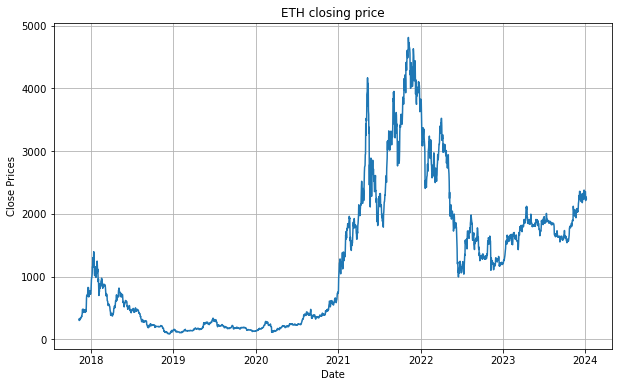

In [2]:
#getting data
today = datetime.today().strftime('%Y-%m-%d')
start_date = '2016-01-01'
eth_df = yf.download('ETH-USD',start_date, today)
eth_df.tail()

# Preprocess data
dataset_ex_df = eth_df.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(dataset_ex_df['Close'])
plt.title('ETH closing price')
plt.show()

<AxesSubplot:title={'center':'ETH price distribution'}, ylabel='Density'>

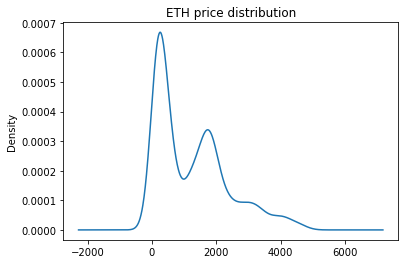

In [3]:
#Distribution of the dataset
df_close = dataset_ex_df['Close']
plt.title('ETH price distribution')
df_close.plot(kind='kde')

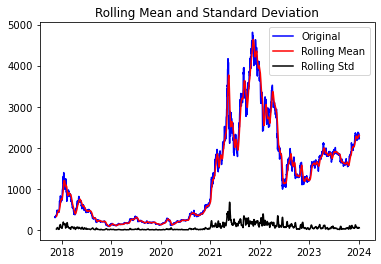

Results of dickey fuller test
Test Statistics                  -1.415149
p-value                           0.574992
No. of lags used                 17.000000
Number of observations used    2232.000000
critical value (1%)              -3.433283
critical value (5%)              -2.862836
critical value (10%)             -2.567460
dtype: float64


In [4]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

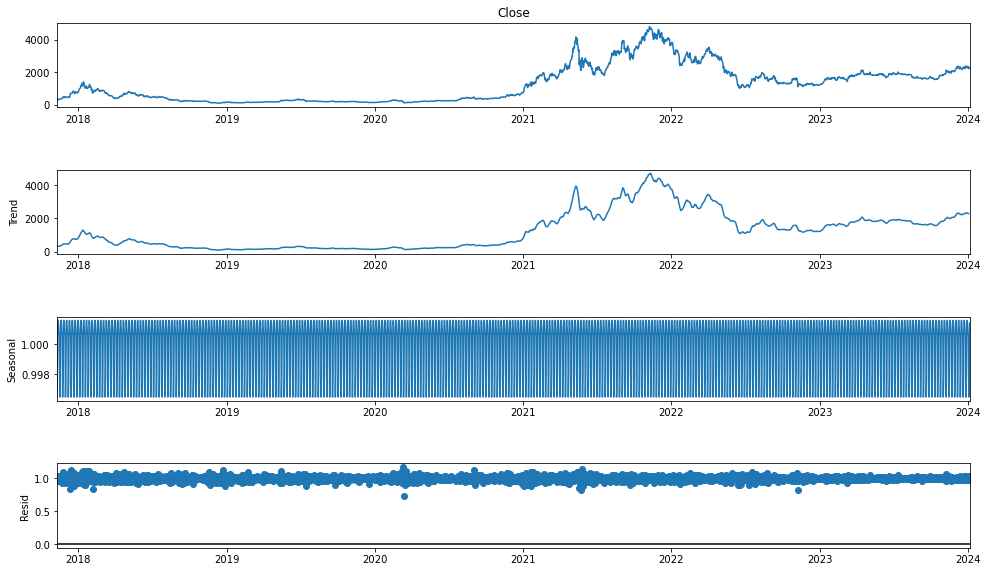

In [5]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


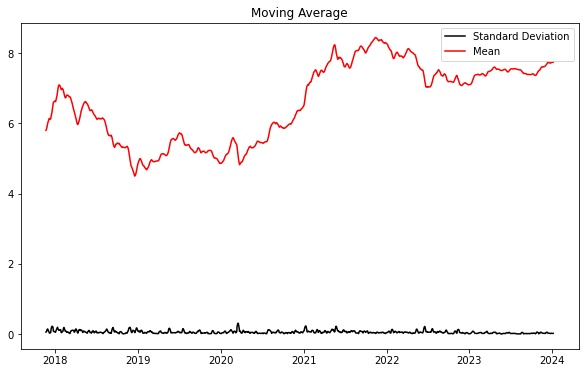

In [6]:
#if not stationary then eliminate trend
#Eliminate trend

rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


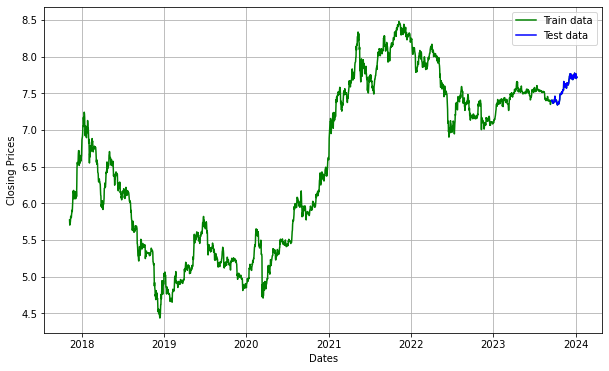

In [7]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_close)*0.95)], df_log[int(len(df_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6818.141, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6819.964, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6819.570, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6819.592, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6824.642, Time=0.80 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6823.404, Time=0.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6825.525, Time=2.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6823.315, Time=2.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6821.459, Time=1.02 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6822.603, Time=4.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6823.748, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6823.187, Time=3.99 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6827.066, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6824.735, Time=0.67 sec
 ARIMA(2,1,0)(0,0,0

In [9]:
# Build Model
model = ARIMA(train_data, order=(2,1,1))  
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2134
Model:                 ARIMA(2, 1, 1)   Log Likelihood                3417.533
Date:                Sun, 07 Jan 2024   AIC                          -6827.066
Time:                        22:08:18   BIC                          -6804.404
Sample:                    11-12-2017   HQIC                         -6818.772
                         - 09-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5902      0.159      3.708      0.000       0.278       0.902
ar.L2          0.0787      0.018      4.458      0.000       0.044       0.113
ma.L1         -0.6329      0.160     -3.955      0.0

                  Close
Date                   
2024-01-05  2268.647217
2024-01-06  2241.624756
2024-01-07    2243.125622
2024-01-08    2242.225347
Freq: D, Name: predicted_mean, dtype: float64


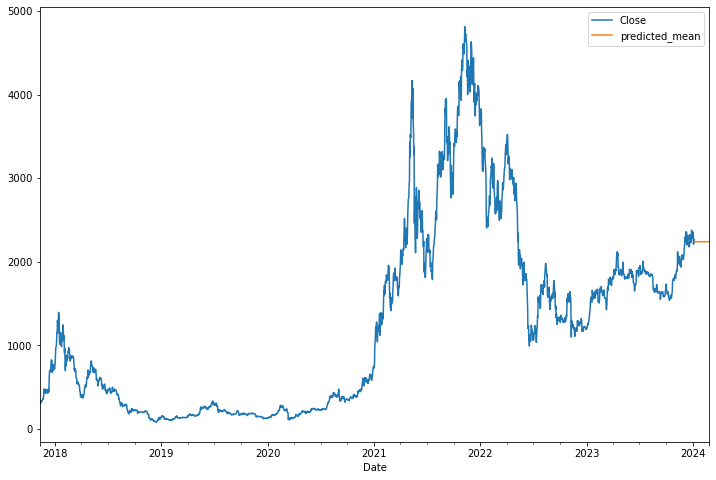

In [18]:
df = dataset_ex_df
model_future = ARIMA(df,order=(2, 1, 1))
results_future = model_future.fit()
predictions_future = results_future.predict(len(df),len(df)+50,typ = 'levels')
df.plot(legend=True , figsize = (12,8))
predictions_future.plot(legend=True)

print(df[-2:])
print(predictions_future[:2])

2024-01-07    2243.125622
2024-01-08    2242.225347
Freq: D, Name: predicted_mean, dtype: float64
